In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df["is_Merchant"] = df["nameDest"].astype(str).str.startswith("M").astype(int)


df['hour'] = df['step'] % 24
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)

# (CASH-IN, CASH-OUT, etc.)
df = pd.get_dummies(df, columns=['type'], prefix='type', dtype='int')

# Apply log1p (log(x+1)) to handle 0s and skewness
cols_to_log = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in cols_to_log:
    # Adding a small constant to ensure we don't log(0) or negative numbers
    # We use log1p which calculates log(1+x)
    df[col] = np.log1p(df[col])

df_clean=df.drop(columns=['nameOrig','nameDest','step','hour'] )#drops irrelevant columns

In [ ]:
df_clean

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,is_Merchant,hour_sin,hour_cos,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9.194276,12.044359,11.984786,0.000000,0.000000,0,0,1,0.258819,0.965926,0,0,0,1,0
1,7.531166,9.964112,9.872292,0.000000,0.000000,0,0,1,0.258819,0.965926,0,0,0,1,0
2,5.204007,5.204007,0.000000,0.000000,0.000000,1,0,0,0.258819,0.965926,0,0,0,0,1
3,5.204007,5.204007,0.000000,9.960954,0.000000,1,0,0,0.258819,0.965926,0,1,0,0,0
4,9.364703,10.634773,10.305174,0.000000,0.000000,0,0,1,0.258819,0.965926,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,12.735768,12.735768,0.000000,0.000000,12.735768,1,0,0,-0.258819,0.965926,0,1,0,0,0
6362616,15.657870,15.657870,0.000000,0.000000,0.000000,1,0,0,-0.258819,0.965926,0,0,0,0,1
6362617,15.657870,15.657870,0.000000,11.134441,15.668663,1,0,0,-0.258819,0.965926,0,1,0,0,0
6362618,13.652996,13.652996,0.000000,0.000000,0.000000,1,0,0,-0.258819,0.965926,0,0,0,0,1


In [ ]:
## The Autoencoders test

In [ ]:
df_fraud=df[df['isFraud']==1]
df_normal=df[df['isFraud']==0]

df_fraud.shape



(8213, 19)

In [ ]:
df_normal.shape

(6354407, 19)

In [ ]:
X_train, X_test_normal = train_test_split(df_normal, test_size=0.2, random_state=42)

# Remove the label column for training
X_train = X_train.drop(['isFraud'], axis=1)
X_test_normal = X_test_normal.drop(['isFraud'], axis=1)

# 3. Create the Final Test Set
# The test set must contain the remaining 20% normal data + ALL fraud data.
# This simulates the real world where we don't know what's coming.

X_test_fraud = df_fraud.drop(['isFraud'], axis=1)

# Combine them
X_test = pd.concat([X_test_normal, X_test_fraud])

# Keep labels for the test set only (so we can evaluate performance later)
y_test = pd.concat([pd.Series(0, index=X_test_normal.index),
                    pd.Series(1, index=X_test_fraud.index)])

print(f"Training Shape: {X_train.shape}") # Should be purely normal data
print(f"Test Shape: {X_test.shape}")      # Mixed data

KeyboardInterrupt: 

In [ ]:
#Scaling

# Use StandardScaler (Zero mean, Unit variance)
scaler = StandardScaler()

# Fit only on training data
scaler.fit(X_train)

# Transform both Training and Test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframe for easier handling (optional, but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Data preprocessing complete.")
print(f"Input Feature Count: {X_train_scaled.shape[1]}")

Data preprocessing complete.
Input Feature Count: 13


In [ ]:
X_train_scaled.shape

(5083525, 13)

In [ ]:
## Full data process for testing

x_full=df.drop(columns=['isFraud'])
y_full=df['isFraud']

# Transform both Training and Test data
X_full_scaled = scaler.transform(x_full)


In [ ]:
import tensorflow as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Get the number of input features automatically
input_dim = X_train_scaled.shape[1]
print(f"Input Dimension: {input_dim}")

# 2. Define the Autoencoder
autoencoder = Sequential()

# --- ENCODER ---
# Input Layer & First Hidden Layer
# We reduce the dimensions slightly (e.g., from ~15 down to 10)
autoencoder.add(Dense(10, activation='relu', input_shape=(input_dim,)))

# Second Hidden Layer (Further compression)
autoencoder.add(Dense(6, activation='relu'))

# --- BOTTLENECK (The most important layer) ---
# This is the latent space. We force the model to represent the transaction
# using only 4 numbers.
autoencoder.add(Dense(3, activation='relu'))

# --- DECODER ---
# We start expanding back to the original size
autoencoder.add(Dense(6, activation='relu'))

# Matching the first hidden layer size
autoencoder.add(Dense(10, activation='relu'))

# --- OUTPUT LAYER ---
# Crucial: The units must equal 'input_dim' to reconstruct the original shape.
# Activation is 'linear' because data is StandardScaled (can be negative).
autoencoder.add(Dense(input_dim, activation='linear'))

# 3. Compile the Model
# Loss: Mean Squared Error (Standard for reconstruction)
# Optimizer: Adam (Standard for adaptive learning)
autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# 4. View the Architecture
autoencoder.summary()

Input Dimension: 13


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 10)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 13)             │           143 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464 (1.81 KB)

 Trainable params: 464 (1.81 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Monitor 'val_loss'. If it doesn't improve for 3 epochs (patience=3), stop.
# restore_best_weights=True ensures we go back to the best version of the model.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# 1. Train the model
# We use X_train_scaled for BOTH input and target
history = autoencoder.fit(
    x=X_full_scaled,
    y=X_full_scaled,
    epochs=100,                # Maximum epochs
    batch_size=128,           # Adjust based on your RAM (64, 128, 256)
    shuffle=True,
    validation_split=0.1,     # Use 10% of training data to check progress
    callbacks=[early_stopping],
    verbose=1
)

# 2. Visualize Training Performance
# We want to see the Loss go down.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/100
44738/44738 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - accuracy: 0.6582 - loss: 0.2349 - val_accuracy: 0.5347 - val_loss: 0.2022
Epoch 2/100
 9975/44738 ━━━━━━━━━━━━━━━━━━━━ 1:34 3ms/step - accuracy: 0.7134 - loss: 0.1939

KeyboardInterrupt: 

In [ ]:
  X_whole=

In [ ]:
# 1. Get the Reconstructions
# The model tries to rebuild the test data
reconstructions = autoencoder.predict(X_full_scaled)

# 2. Calculate Mean Squared Error (MSE) for each row
# Formula: mean((Input - Output)^2)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Add this error to a dataframe for analysis
error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test
})

print(error_df.head())

198832/198832 ━━━━━━━━━━━━━━━━━━━━ 291s 1ms/step


In [ ]:
import tensorflow as tf
import pandas as  pd

In [ ]:
# 1. Reset the index of y_test to drop the old row numbers
# drop=True prevents the old index from being added as a new column
y_test = y_test.reset_index(drop=True)

# 2. Now create the DataFrame
error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test
})

# 3. Check again - NaNs should be gone
print(error_df.head())
print("Missing values:", error_df.isnull().sum())

   reconstruction_error  true_class
0              0.008871           0
1              0.048642           0
2              0.006320           0
3              0.006789           0
4              0.018444           0
Missing values: reconstruction_error    0
true_class              0
dtype: int64


In [ ]:
# Option A: Statistical Threshold (Mean + 3 Standard Deviations)
# We calculate this based ONLY on the Normal transactions in our error list
# (Filtering by true_class==0 just to find the reference point)
normal_error_df = error_df[error_df['true_class'] == 0]

threshold = normal_error_df['reconstruction_error'].mean() + (3 * normal_error_df['reconstruction_error'].std())

print(f"Cut-off Threshold: {threshold}")

# Option B: Percentile Threshold (Simpler)
# "Flag the top 1% of highest errors as fraud"
# threshold = np.percentile(error_df['reconstruction_error'], 99)

Cut-off Threshold: 0.22525868920629935


In [ ]:
threshold=0.1

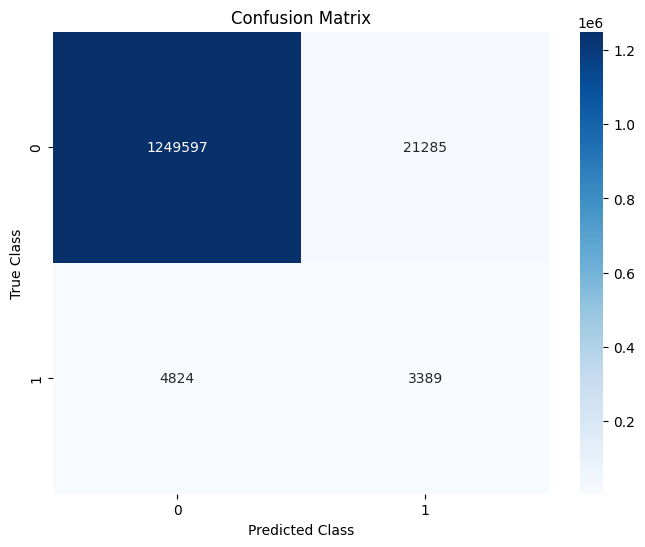

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270882
           1       0.14      0.41      0.21      8213

    accuracy                           0.98   1279095
   macro avg       0.57      0.70      0.60   1279095
weighted avg       0.99      0.98      0.98   1279095



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 1. Create Predictions
# If error > threshold, predict 1 (Fraud), else 0 (Normal)
y_pred = [1 if e > threshold else 0 for e in error_df['reconstruction_error'].values]

# 2. The Confusion Matrix
conf_matrix = confusion_matrix(error_df['true_class'], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()



# 3. Precision & Recall (The most important metrics)
print(classification_report(error_df['true_class'], y_pred))

In [ ]:
from sklearn.metrics import precision_recall_curve

# 1. Calculate Precision-Recall for different thresholds
precision, recall, thresholds = precision_recall_curve(error_df['true_class'], error_df['reconstruction_error'])

# 2. Calculate F1 Score for each threshold
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# We add a small epsilon (1e-10) to avoid division by zero
numerator = 2 * precision * recall
denominator = precision + recall + 1e-10
fscore = numerator / denominator

# 3. Find the index of the best F1 Score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1-Score: {fscore[ix]}')
print(f'Recall at Best Threshold: {recall[ix]}')
print(f'Precision at Best Threshold: {precision[ix]}')

Best Threshold: 0.3258206234907466
Best F1-Score: 0.23704858906451937
Recall at Best Threshold: 0.29611591379520275
Precision at Best Threshold: 0.19762717373638874


In [ ]:
# Re-run predictions with the optimized threshold
y_pred_optimized = [1 if e > best_threshold else 0 for e in error_df['reconstruction_error'].values]

print(classification_report(error_df['true_class'], y_pred_optimized))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270882
           1       0.20      0.30      0.24      8213

    accuracy                           0.99   1279095
   macro avg       0.60      0.64      0.62   1279095
weighted avg       0.99      0.99      0.99   1279095



In [ ]:
len(y_pred)

1279095

In [ ]:
## Doing the time based spplit



TIME BASED SPLIT


In [ ]:
# --- 3. DEFINE TIME CUTOFFS (3-Way Split) ---
# Total steps = 744 (30 Days)
# Train: Days 1-20 (Steps 0-480) -> Pure Normal
# Val:   Days 21-25 (Steps 481-600) -> Mixed (To tune threshold)
# Test:  Days 26-30 (Steps 601-744) -> Mixed (To evaluate)

train_limit = 480
val_limit = 600

# TRAIN SET (Historical Normal Data Only)
X_train = df_clean[(df['step'] <= train_limit) & (df['isFraud'] == 0)]
X_train = X_train.drop(['isFraud'], axis=1, errors='ignore')

# VAL SET (Recent Past - Mixed)
df_val = df_clean[(df['step'] > train_limit) & (df['step'] <= val_limit)]
X_val = df_val.drop(['isFraud'], axis=1, errors='ignore')
y_val = df_val['isFraud']

# TEST SET (Future - Mixed)
df_test = df_clean[df['step'] > val_limit]
X_test = df_test.drop(['isFraud'], axis=1, errors='ignore')
y_test = df_test['isFraud']

print(f"Train Shape (Past Normal):   {X_train.shape}")
print(f"Val Shape   (Recent Mixed):  {X_val.shape}")
print(f"Test Shape  (Future Mixed):  {X_test.shape}")

Train Shape (Past Normal):   (6034094, 14)
Val Shape   (Recent Mixed):  (219604, 14)
Test Shape  (Future Mixed):  (103573, 14)


In [ ]:
scaler = StandardScaler()

# Fit on Train
scaler.fit(X_train)

# Transform all
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1

input_dim = X_train_scaled.shape[1]
autoencoder = Sequential()

# Encoder
autoencoder.add(Dense(16, activation='relu', input_shape=(input_dim,)))
autoencoder.add(Dense(8, activation='relu', activity_regularizer=l1(10e-5)))

# Bottleneck (4 neurons)
autoencoder.add(Dense(4, activation='relu'))

# Decoder
autoencoder.add(Dense(8, activation='relu'))
autoencoder.add(Dense(16, activation='relu'))

# Output
autoencoder.add(Dense(input_dim, activation='linear'))

# Compile with MAE
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    x=X_train_scaled,
    y=X_train_scaled,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 274s 3ms/step - loss: 0.2493 - val_loss: 0.2410
Epoch 2/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 266s 3ms/step - loss: 0.2234 - val_loss: 0.2407
Epoch 3/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 257s 3ms/step - loss: 0.2175 - val_loss: 0.2099
Epoch 4/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 252s 3ms/step - loss: 0.1963 - val_loss: 0.2091
Epoch 5/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 265s 3ms/step - loss: 0.1959 - val_loss: 0.2088
Epoch 6/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 251s 3ms/step - loss: 0.1926 - val_loss: 0.2011
Epoch 7/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 246s 3ms/step - loss: 0.1895 - val_loss: 0.2014
Epoch 8/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 237s 3ms/step - loss: 0.1886 - val_loss: 0.2014
Epoch 9/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 221s 2ms/step - loss: 0.1849 - val_loss: 0.1958
Epoch 10/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 221s 2ms/step - loss: 0.1817 - val_loss: 0.1890
Epoch 11/50
94283/94283 ━━━━━━━━━━━━━━━━━━━━ 221s 2ms/step - loss: 0.1743 - val

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report

# 1. Optimize Threshold on VAL set
val_preds = autoencoder.predict(X_val_scaled)
val_mae = np.mean(np.abs(X_val_scaled - val_preds), axis=1)

precision, recall, thresholds = precision_recall_curve(y_val, val_mae)
fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
best_threshold = thresholds[ix]

print(f"Best Threshold (from Validation): {best_threshold}")

# 2. Final Test on FUTURE data
test_preds = autoencoder.predict(X_test_scaled)
test_mae = np.mean(np.abs(X_test_scaled - test_preds), axis=1)

# Apply threshold
y_pred_future = [1 if e > best_threshold else 0 for e in test_mae]

print("-" * 30)
print("RESULTS ON FUTURE DATA (DAYS 26-30)")
print("-" * 30)
print(classification_report(y_test, y_pred_future))

6863/6863 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Best Threshold (from Validation): 0.46743272287451504
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
------------------------------
RESULTS ON FUTURE DATA (DAYS 26-30)
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    101973
           1       0.76      0.54      0.63      1600

    accuracy                           0.99    103573
   macro avg       0.88      0.77      0.81    103573
weighted avg       0.99      0.99      0.99    103573



In [ ]:
#Time based split + autoencoders+ xgboost